# Исследование: анализ тарифов - какой выгоднее?

Входные данные:

- данные о 500 пользователей в разрезе тарифов и регионов, 
- стоимость услуг в тарифах,
- количество звонков, SMS и мегбайт они сделали в течение года.

<font color=orange>Нам необходимо определить, в рекламу какого какого тарифа выгоднее вложить средства. Для этого на основании данных о пользовании услугами мы определим полные затраты пользователей, сгруппированные по месяцам и тарифам.</font>

<font color=green>Затем мы сравним параметры полученных выборок - средние значения, разброс параметров и пр. На осовании этих данных возможно опредеить, пользователи какого тарифа в среднем приносят больше денег компании. А если больше прибыль, следовательно в это предприятие выгоднее и вкладываться.</font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math as mth

Прочитаем данные из файлов

In [2]:
#C:/Users/IAS/Documents/Statistics/
users_data = pd.read_csv('/datasets//users.csv')
users_data.info()
users_data.head()

calls_data = pd.read_csv('/datasets/calls.csv')
calls_data.info()
calls_data.head()

messages_data = pd.read_csv('/datasets/messages.csv')
messages_data.info()
messages_data.head()

internet_data = pd.read_csv('/datasets/internet.csv', index_col=0)
internet_data.info()
internet_data.head()

tariffs_data = pd.read_csv('/datasets/tariffs.csv')
tariffs_data.info()
tariffs_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Вывод по данным файлов

Количество данных в каждой таблице разное. Все данные заполнены, пустых значений нет. 

В таблице пользователей не заполнена дата отключения тарифа, но он, скорее всего, действовал на момент сбора статистики. Для текущего исследования это не важно, к тому же пользователей, отказавшихся от использования определенного тарифа очень мало.

Звонки с пустым временем есть, определить почему они возникли из данных нельзя, посчитаем два разных количества звонков - с учетом нулевых значений и без их учета.

In [3]:
# Добавим в таблицу пользователей категорийное значение "Другие города" 
# для всех городов, кроме Москвы

def city_category(row):
    if row['city'] == 'Москва':
        return 'Пользователи Москвы'
    else:
        return 'Пользователи других регионов'

users_data['city_category'] = users_data.apply(city_category, axis=1)    

users_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,city_category
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Пользователи других регионов
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,Пользователи Москвы
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,Пользователи других регионов
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,Пользователи Москвы
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,Пользователи других регионов


In [4]:
# Обработаем таблицы (нулевые значения, типы, дубли), 
# сформируем сводные таблицы параметров для определения 
# стоимости каждого месяца каждого пользователя

# Обработаем таблицу звонков

# Удалим нулевые звонки
calls_data = calls_data[calls_data['duration']!=0]


# Преобразуем дату и создадим колонку со значением месяца
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
calls_data['use_month'] = calls_data['call_date'].dt.month

# Добавим колонку для подсчета ненулевых звонков
def non_null_call(row):
    if row['duration'] == 0:
        return 0
    else:
        return 1


# Округлим колонку длительности до целого числа вверх
def round_up_calls(row):
    return mth.ceil(row['duration'])

#calls_data['non_null_call'] = calls_data.apply(non_null_call, axis = 1)

calls_data['duration_up'] = calls_data.apply(round_up_calls, axis = 1)


# сформируем сводную таблицу по пользователям и месяцам с количеством звонков
# (две колонки - с нулевыми звонками и без) и общей длительностью звонков по месяцам

calls_data_pivot = calls_data.pivot_table(index = ['user_id','use_month'],
#                                         values = ['duration_up','non_null_call'], 
                                         values = ['duration_up'], 
                                         aggfunc = ['count','sum']) 
                                          

#calls_data_pivot.columns = ['calls_all','for_deletion', 'calls_duration','calls_non_null']
calls_data_pivot.columns = ['calls_all','calls_duration']
calls_data_grouped = calls_data_pivot.reset_index()
calls_data_grouped.head()

,user_id,use_month,calls_all,calls_duration
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466


In [5]:
# Обработаем таблицу сообщений

# Преобразуем дату и создадим колонку со значением месяца
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')
messages_data['use_month'] = messages_data['message_date'].dt.month

# сформируем сводную таблицу по пользователям и месяцам с количеством сообщений

messages_data_pivot = messages_data.pivot_table(index = ['user_id','use_month'],
                                         values = ['id'], 
                                         aggfunc = ['count']) 
                                          

messages_data_pivot.columns = ['messages_all']
messages_data_grouped = messages_data_pivot.reset_index()
messages_data_grouped.head()

,user_id,use_month,messages_all
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


<font color=orange>

1. Появление нулевого значения траффика в определенной сессии возможно в случае соединения в точке отсутствия высокоскоростного покрытия. Например, если на базовой станции максимальное соединение - GPRS или даже EDGE.
2. На итоговый расчет эти значения никак не влияют, т.к. нам необходим общий объем траффика за месяц, а к нему сколько нулей ни прибавляй, значение не изменится. Количество сессий соединения мы в данном исследовании не изучаем.
3. Однако соглашусь, что при больших объемах выборки, такие значения будут замедлять общую обработку. Поэтому исключим эти строки из выборки до расчета.
    
</font>


In [19]:
# Обработаем таблицу траффика

# Удалим строки с нулевыми значениями траффика
#internet_data_non_null = internet_data[internet_data['mb_used']!=0]
internet_data_non_null = internet_data.query('mb_used!=0')

# Преобразуем дату, создадим колонку со значением месяца

internet_data_non_null['session_date'] = pd.to_datetime(internet_data_non_null['session_date'], format='%Y-%m-%d')
internet_data_non_null['use_month'] = internet_data_non_null['session_date'].dt.month

# Округлим колонку траффика до целого числа вверх
def round_up_traffic(row):
    return mth.ceil(row['mb_used'])

internet_data_non_null['mb_used_up'] = internet_data_non_null.apply(round_up_traffic, axis = 1)


# сформируем сводную таблицу по пользователям и месяцам с количеством мегабайт
internet_data_pivot = internet_data_non_null.pivot_table(index = ['user_id','use_month'],
                                         values = ['mb_used_up'], 
                                         aggfunc = ['sum']) 
                                          
internet_data_pivot.columns = ['mb_per_month_all']

# на этом этапе можно трафик в целые мегабайты переименовать
internet_data_pivot['mb_per_month_all'] = internet_data_pivot['mb_per_month_all'].astype('int')

# преобразуем для удобства в плоскую таблицу
internet_data_grouped = internet_data_pivot.reset_index()
internet_data_grouped.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,user_id,use_month,mb_per_month_all
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


<font color=red>Я использовал левые соединения таблиц для тех случаев, когда я точно понимаю, что в левой таблице есть необходимые данные, а именно для присоединения к таблице с данными о использовании услуг, данных о тарифе. В случае, когда я создавал полную таблицу услуг, я использовал внешнее соединение.</font>

In [7]:
# Создадаим таблицы для расчета затрат

# Склеим таблицу пользователей и тарифов
tariffs_data.rename(columns={'tariff_name': 'tariff'}, inplace=True)
users_tariffs_data = users_data.merge(tariffs_data, on='tariff', how='left')

# Сформируем таблицы для расчета стоимости каждой из услуг
calls_tariffs_data = users_tariffs_data[['user_id', 'tariff', 'rub_monthly_fee', 'minutes_included', 'rub_per_minute']]
messages_tariffs_data = users_tariffs_data[['user_id', 'tariff','rub_monthly_fee', 'messages_included', 'rub_per_message']]
internet_tariffs_data = users_tariffs_data[['user_id', 'tariff', 'rub_monthly_fee', 'mb_per_month_included', 'rub_per_gb']]

# Склеим таблицы по месяцам с таблицами данных о тарифах для расчета затрат
calls_loses_data = calls_data_grouped.merge(calls_tariffs_data, on='user_id', how='left')

messages_loses_data = messages_data_grouped.merge(messages_tariffs_data, on='user_id', how='left')

internet_loses_data = internet_data_grouped.merge(internet_tariffs_data, on='user_id', how='left')

# Рассчитаем затраты месячные затраты каждого пользователя по каждой услуге

# Создадаим функции для расчета
def calls_over_tariff(row):
    if row['minutes_included'] >= row['calls_duration']:
        return 0
    else:
        return (row['calls_duration'] - row['minutes_included'])

def messages_over_tariff(row):
    if row['messages_included'] >= row['messages_all']:
        return 0
    else:
        return (row['messages_all'] - row['messages_included'])

def internet_over_tariff(row):
    if row['mb_per_month_included'] >= row['mb_per_month_all']:
        return 0
    else:
        return (row['mb_per_month_all'] - row['mb_per_month_included'])


# Посчитаем затраты сверх нормы в базовых единицах и в рублях
calls_loses_data['calls_over_tariff'] = calls_loses_data.apply(calls_over_tariff, axis=1)
messages_loses_data['messages_over_tariff'] = messages_loses_data.apply(messages_over_tariff, axis=1)
internet_loses_data['internet_over_tariff'] = internet_loses_data.apply(internet_over_tariff, axis=1)

calls_loses_data['calls_over_tariff_rub'] = calls_loses_data['calls_over_tariff'] * calls_loses_data['rub_per_minute']
messages_loses_data['messages_over_tariff_rub'] = messages_loses_data['messages_over_tariff'] * messages_loses_data['rub_per_message']
internet_loses_data['internet_over_tariff_rub'] = internet_loses_data['internet_over_tariff'] * internet_loses_data['rub_per_gb'] / 1024

# Склеим все расчетные данные в единую таблицу.
# Используем полное соединение, т.к. где-то данных может не быть.
calls_and_messages_loses_data = calls_loses_data.merge(messages_loses_data, on=['user_id','use_month','tariff','rub_monthly_fee'], how='outer')
all_count_data = calls_and_messages_loses_data.merge(internet_loses_data, on=['user_id','use_month','tariff','rub_monthly_fee'], how='outer')

all_count_data.info()

# Все пустые поля, получившиеся при склеивании таблиц заменим нулями, прежде чем считать общие затраты
# Если пользователь пользовался тарифом в этом периоде, значит мы можем предположить, 
# что он просто не использовал определенную услугу в этом же периоде.

all_count_data = all_count_data.fillna(0)

all_count_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
user_id                     3214 non-null int64
use_month                   3214 non-null int64
calls_all                   3168 non-null float64
calls_duration              3168 non-null float64
tariff                      3214 non-null object
rub_monthly_fee             3214 non-null int64
minutes_included            3168 non-null float64
rub_per_minute              3168 non-null float64
calls_over_tariff           3168 non-null float64
calls_over_tariff_rub       3168 non-null float64
messages_all                2717 non-null float64
messages_included           2717 non-null float64
rub_per_message             2717 non-null float64
messages_over_tariff        2717 non-null float64
messages_over_tariff_rub    2717 non-null float64
mb_per_month_all            3201 non-null float64
mb_per_month_included       3201 non-null float64
rub_per_gb                  3201 non-null float64


In [8]:
# Посчитаем затраты сверх тарифа
all_count_data['extra_monthly_fee'] = (all_count_data['calls_over_tariff_rub'] +
                                      all_count_data['messages_over_tariff_rub'] +
                                      all_count_data['internet_over_tariff_rub'])

# Посчитаем полные затраты пользователей
all_count_data['full_monthly_fee'] = (all_count_data['rub_monthly_fee'] + 
                                      all_count_data['extra_monthly_fee'])

all_loses_data = all_count_data[['user_id',
                                 'use_month',
                                 'tariff',
                                 'rub_monthly_fee',
                                 'calls_over_tariff',
                                 'messages_over_tariff',
                                 'internet_over_tariff',
                                 'calls_over_tariff_rub',
                                 'messages_over_tariff_rub',
                                 'internet_over_tariff_rub',
                                 'extra_monthly_fee',
                                 'full_monthly_fee',
                                 'calls_all',
#                                 'calls_non_null',
                                 'calls_duration',
                                 'messages_all',
                                 'mb_per_month_all',
                                ]]

city_categories_data = users_data[['user_id','city_category']]

all_loses_data = all_loses_data.merge(city_categories_data,on=['user_id'], how='left')

all_loses_data.head(20)

all_loses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 17 columns):
user_id                     3214 non-null int64
use_month                   3214 non-null int64
tariff                      3214 non-null object
rub_monthly_fee             3214 non-null int64
calls_over_tariff           3214 non-null float64
messages_over_tariff        3214 non-null float64
internet_over_tariff        3214 non-null float64
calls_over_tariff_rub       3214 non-null float64
messages_over_tariff_rub    3214 non-null float64
internet_over_tariff_rub    3214 non-null float64
extra_monthly_fee           3214 non-null float64
full_monthly_fee            3214 non-null float64
calls_all                   3214 non-null float64
calls_duration              3214 non-null float64
messages_all                3214 non-null float64
mb_per_month_all            3214 non-null float64
city_category               3214 non-null object
dtypes: float64(12), int64(3), object(2)
memory usa

In [9]:
all_loses_data

,user_id,use_month,tariff,rub_monthly_fee,calls_over_tariff,messages_over_tariff,internet_over_tariff,calls_over_tariff_rub,messages_over_tariff_rub,internet_over_tariff_rub,extra_monthly_fee,full_monthly_fee,calls_all,calls_duration,messages_all,mb_per_month_all,city_category
0,1000,5,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000,17.0,159.0,22.0,2256.0,Пользователи других регионов
1,1000,6,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000,28.0,172.0,60.0,23257.0,Пользователи других регионов
2,1000,7,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000,41.0,340.0,75.0,14016.0,Пользователи других регионов
3,1000,8,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000,42.0,408.0,81.0,14070.0,Пользователи других регионов
4,1000,9,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000,46.0,466.0,57.0,14581.0,Пользователи других регионов
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,smart,550,0.0,0.0,4228.0,0.0,0.0,825.781250,825.781250,1375.781250,0.0,0.0,21.0,19588.0,Пользователи других регионов
3210,1489,11,smart,550,0.0,0.0,2156.0,0.0,0.0,421.093750,421.093750,971.093750,0.0,0.0,20.0,17516.0,Пользователи других регионов
3211,1489,12,smart,550,0.0,0.0,1981.0,0.0,0.0,386.914062,386.914062,936.914062,0.0,0.0,35.0,17341.0,Пользователи других регионов
3212,1240,2,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1950.000000,0.0,0.0,0.0,961.0,Пользователи других регионов


In [10]:
# Функции для построения диаграмм

# Функция вывода текста на графике
def add_titlebox(ax, text, x_point, y_point):
    ax.text(x_point, y_point, text,
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.6),
        fontsize=12.5)
    return ax

# Функция для формирования двух диаграм рядом
def df_two_histograms(dataframe1, 
                      dataframe2, 
                      frame_name1, 
                      frame_name2, 
                      description_name, 
                      figure_number,
                      bins_number,
                      xlim_min,
                      xlim_max):

    # Определим параметры графиков
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2,
        figsize=(16, 6)
    )

    plt.figure(figure_number)

    #plt.title(description_name)
    
    plt.gca().set(title=description_name) #, ylabel='Frequency')

    ax1.hist(dataframe1, bins='auto', color = 'g', label = frame_name1)
    ax1.hist(dataframe2, bins='auto', color = 'b', label = frame_name2)

    ax2.hist(dataframe1, bins='auto', color = 'g', label = frame_name1)
    ax2.hist(dataframe2, bins='auto', color = 'b', label = frame_name2)

    plt.xlim(xlim_min,xlim_max)
    
    add_titlebox(ax1, 'Все значения',.55,.8)
    add_titlebox(ax2, 'Без выбросов',.55,.8)

    plt.legend()
    plt.plot()
    

# Функция для формирования диаграммы с двумя датафреймами
def two_df_one_histogram(dataframe1, 
                         dataframe2,
                         frame_name1, 
                         frame_name2, 
                         diagram_name, 
                         column_name, 
                         figure_number,
                         y_label):

    # Plot
    plt.figure(figure_number, figsize=(8,5), dpi= 80)
    
    plt.grid()

    #plt.title(description_name)
    
    plt.gca().set(title=diagram_name , ylabel=y_label)

    plt.hist(dataframe1[column_name], bins='auto', color = 'g', label = frame_name1, alpha = 0.5)
    plt.hist(dataframe2[column_name], bins='auto', color = 'b', label = frame_name2, alpha = 0.5)

    #add_titlebox(plt, 'Все значения',.55,.8)
    
    plt.legend()
    plt.plot()


Тариф Ультра

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 3213
Data columns (total 17 columns):
user_id                     985 non-null int64
use_month                   985 non-null int64
tariff                      985 non-null object
rub_monthly_fee             985 non-null int64
calls_over_tariff           985 non-null float64
messages_over_tariff        985 non-null float64
internet_over_tariff        985 non-null float64
calls_over_tariff_rub       985 non-null float64
messages_over_tariff_rub    985 non-null float64
internet_over_tariff_rub    985 non-null float64
extra_monthly_fee           985 non-null float64
full_monthly_fee            985 non-null float64
calls_all                   985 non-null float64
calls_duration              985 non-null float64
messages_all                985 non-null float64
mb_per_month_all            985 non-null float64
city_category               985 non-null object
dtypes: float64(12), int64(3), object(2)
memory usage: 

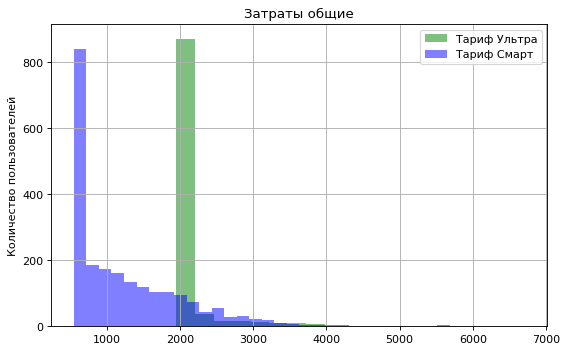

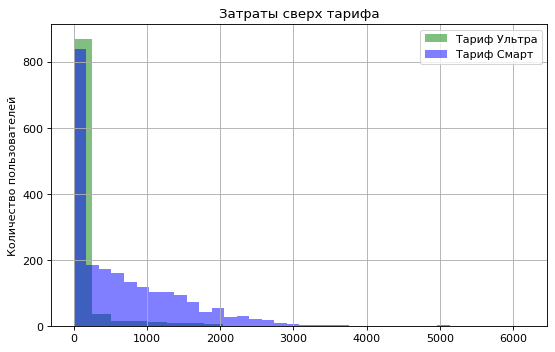

In [11]:
# Отберем таблицы по тарифам и построим гистограммы общих затрат

ultra_loses_data = all_loses_data.query('tariff == "ultra"')
smart_loses_data = all_loses_data.query('tariff == "smart"')


print('Тариф Ультра')
print('')
ultra_loses_data.info()
print('')
print('Тариф Смарт')
print('')
smart_loses_data.info()
print('')

# Затраты общие в разрезе тарифов
two_df_one_histogram(ultra_loses_data, 
                     smart_loses_data,
                     'Тариф Ультра', 
                     'Тариф Смарт', 
                     'Затраты общие', 
                     'full_monthly_fee', 
                     0,
                     'Количество пользователей')

# Затраты сверх тарифа в разрезе тарифов
two_df_one_histogram(ultra_loses_data, 
                     smart_loses_data,
                     'Тариф Ультра', 
                     'Тариф Смарт', 
                     'Затраты сверх тарифа', 
                     'extra_monthly_fee', 
                     1,
                     'Количество пользователей')


## Вывод по сравенению тарифов на предмет затрат сверх месячной абонплаты

    1. Пользователей, использующих тариф 'Смарт' явно больше, т.к. он дешевле. 
    2. Однако пользователей, тратящих больше денег сверх тарифа среди них больше, чем среди тех, кто использует тариф Ультра'

Необходимо подробнее рассмотреть, какова структура затрат пользователей

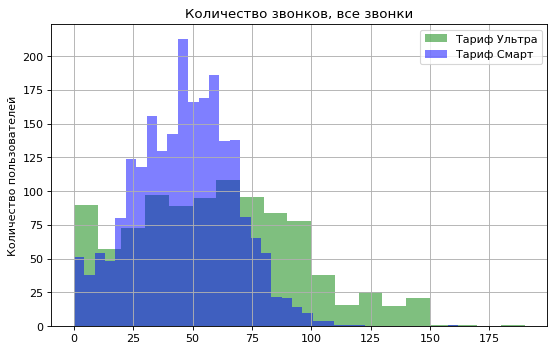

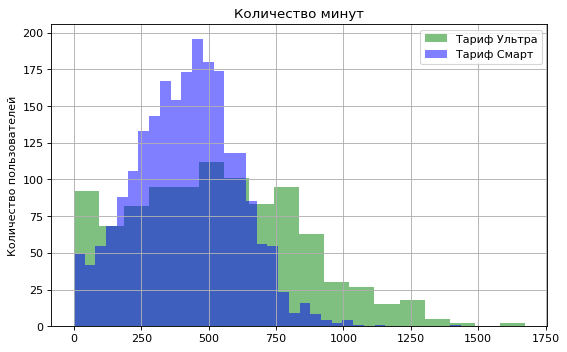

In [12]:
# А теперь займемся статистикой

# Количество звонков всего
two_df_one_histogram(ultra_loses_data, 
                     smart_loses_data,
                     'Тариф Ультра', 
                     'Тариф Смарт', 
                     'Количество звонков, все звонки', 
                     'calls_all', 
                     2,
                     'Количество пользователей')

# Количество звонков ненулевых
#two_df_one_histogram(ultra_loses_data, 
#                     smart_loses_data,
#                     'Тариф Ультра', 
#                     'Тариф Смарт', 
#                     'Количество звонков, ненулевые звонки', 
#                     'calls_non_null', 
#                     3,
#                     'Количество пользователей')

# Количество минут
two_df_one_histogram(ultra_loses_data, 
                     smart_loses_data,
                     'Тариф Ультра', 
                     'Тариф Смарт', 
                     'Количество минут', 
                     'calls_duration', 
                     4,
                     'Количество пользователей')


## Вывод по результатам анализа гистограмм (часть 1)

Гистограмма распределения количества минут и количества звонков по тарифам очень похожа. Проверим далее статистически параметры этих выборок.

Распределение количества звонков, как и распределение количества минут, затрачиваемых пользователями обоих тарифов, это нормальное распределение. Никто не покупает тариф, чтобы им не пользовться, но есть месяцы, в которых люди вообще не звонят или звонят мало. Т.к. услуги в тарифе у нас три, то в выборку попадают и нулевые значения по некоторым месяцам.

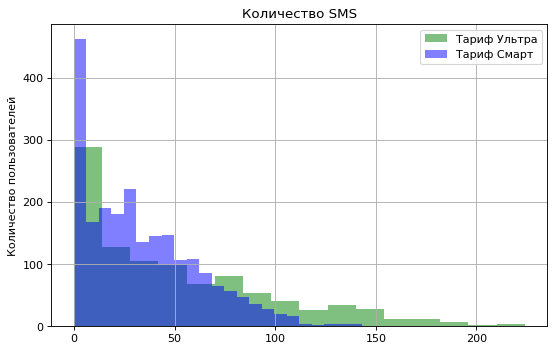

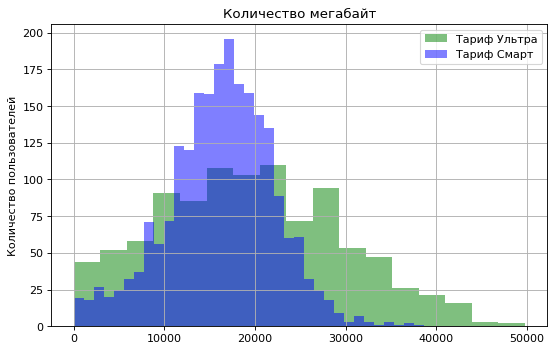

In [13]:
# Количество смс
two_df_one_histogram(ultra_loses_data, 
                     smart_loses_data,
                     'Тариф Ультра', 
                     'Тариф Смарт', 
                     'Количество SMS', 
                     'messages_all', 
                     5,
                     'Количество пользователей')

# Количество мегабайт
two_df_one_histogram(ultra_loses_data, 
                     smart_loses_data,
                     'Тариф Ультра', 
                     'Тариф Смарт', 
                     'Количество мегабайт', 
                     'mb_per_month_all', 
                     6,
                     'Количество пользователей')


## Вывод по результатам анализа гистограмм (часть 2)

Количество СМС - типичное распределение Пуассона. В эпоху мессенджеров люди редко пишут сообщения, поэтому нулевых значений очень много.

Распределение количества мегабайт - также подчиняется нормальному распределению. Как я уже писал ранее, никто не покупает тариф, чтобы им не пользовться, но есть месяцы, в которых люди вообще не пользуются какой-либо услугой.

In [14]:
# Создадаим массив строк
rows_list = []

# Напишем функцию для добавления строки в массив
def df_statistic_append(dataframe,
                        column_name,
                        sample_column_name,
                        sample_name,
                        indicator_name):
    
    local_series = dataframe[column_name]

    variance_estimate = np.var(local_series, ddof=1)
    standard_deviation = np.std(local_series, ddof=1)

    local_dict = {sample_column_name: sample_name,
                  'indicator': indicator_name, 
                  'mean_value': local_series.mean(),
                  'median_value': local_series.median(),
                  'variance_value': variance_estimate,
                  'std_dev_value': standard_deviation
                 }
    rows_list.append(local_dict)

# Добавим строки с параметрами
df_statistic_append(ultra_loses_data,
                    'calls_duration',
                    'tariff',
                    'Тариф Ультра',
                    'Длительность звонков')

df_statistic_append(smart_loses_data,
                    'calls_duration',
                    'tariff',
                    'Тариф Смарт',
                    'Длительность звонков')

df_statistic_append(ultra_loses_data,
                    'messages_all',
                    'tariff',
                    'Тариф Ультра',
                    'Количество SMS')

df_statistic_append(smart_loses_data,
                    'messages_all',
                    'tariff',
                    'Тариф Смарт',
                    'Количество SMS')

df_statistic_append(ultra_loses_data,
                    'mb_per_month_all',
                    'tariff',
                    'Тариф Ультра',
                    'Количество Мб')

df_statistic_append(smart_loses_data,
                    'mb_per_month_all',
                    'tariff',
                    'Тариф Смарт',
                    'Количество Мб')

# Преобразуем массив в датафрейм
statistic_data_tariffs = pd.DataFrame(rows_list)

statistic_data_tariffs

,tariff,indicator,mean_value,median_value,variance_value,std_dev_value
0,Тариф Ультра,Длительность звонков,526.623350,518.0,1.008736e+05,317.606098
1,Тариф Смарт,Длительность звонков,417.934948,422.0,3.621932e+04,190.313730
2,Тариф Ультра,Количество SMS,49.363452,38.0,2.285266e+03,47.804457
3,Тариф Смарт,Количество SMS,33.384029,28.0,7.968130e+02,28.227876
4,Тариф Ультра,Количество Мб,19486.901523,19324.0,1.019356e+08,10096.317202
5,Тариф Смарт,Количество Мб,16229.188425,16531.0,3.454591e+07,5877.576978


## Вывод по результатам анализа статистических параметров пользователей различных тарифов

С точки зрения количества звонков среднее и медиана практически не отличаются между собой в различных тарифах. Это значит, что аномально большого количества минут практически не выговаривается. Однако стоит заметить, что среднее количество выговариваемых минут не сильно отличается в обоих тарифных планах. В тарифе 'Ультра' большинсво пользователей по звонкам не выходит за пределы своего тарифного плана, зато в тарифе 'Смарт' таких достаточно много.

Количество СМС - этот параметр нельзя брать в расчет как значимую величину при формировании тарифа. Технология в массе своей вымирает. Даже пользователи тарифа 'Смарт', крайне редко превышают лимит, заложенный в пакет.

Ключевым фактором, формирующим затраты пользователей, является интернет-траффик. Пользователи тарифа 'Смарт' тратят не существенно меньше, чем пользователи тарифа 'Ультра'. И, кроме того, в среднем превышают заложенный в пакет объем траффика.

In [15]:
# Создадаим массив строк
rows_list = []

# Добавим строки с параметрами
df_statistic_append(ultra_loses_data,
                    'full_monthly_fee',
                    'tariff',
                    'Тариф Ультра',
                    'Средняя выручка')

df_statistic_append(smart_loses_data,
                    'full_monthly_fee',
                    'tariff',
                    'Тариф Смарт',
                    'Средняя выручка')

# Преобразуем массив в датафрейм
statistic_data_tariffs_rub = pd.DataFrame(rows_list)

statistic_data_tariffs_rub

,tariff,indicator,mean_value,median_value,variance_value,std_dev_value
0,Тариф Ультра,Средняя выручка,2060.529971,1950.000000,126953.285460,356.305046
1,Тариф Смарт,Средняя выручка,1233.349467,959.898438,620452.607534,787.688141


In [16]:
# Сделаем выборки по Москве и регионам. Мы их ранее не делали
msk_loses_data = all_loses_data.query('city_category == "Пользователи Москвы"')
reg_loses_data = all_loses_data.query('city_category == "Пользователи других регионов"')

# Создадаим массив строк
rows_list = []

# Добавим строки с параметрами
df_statistic_append(msk_loses_data,
                    'full_monthly_fee',
                    'region',
                    'Москва',
                    'Средняя выручка')

df_statistic_append(reg_loses_data,
                    'full_monthly_fee',
                    'region',
                    'Регионы',
                    'Средняя выручка')

# Преобразуем массив в датафрейм
statistic_data_regions = pd.DataFrame(rows_list)

statistic_data_regions

,region,indicator,mean_value,median_value,variance_value,std_dev_value
0,Москва,Средняя выручка,1507.276762,1704.632812,547242.749893,739.758575
1,Регионы,Средняя выручка,1482.063727,1518.078125,630503.854635,794.042728


## Вывод по результатам анализа статистических параметров затрат пользователей различных тарифов и регионов

Средняя выручка от тарифа 'Ультра' не отличается от ежемесячного платежа за этот тариф. Пользователи редко превышают этот платеж, а если и превышают, то не намного. Что касается тарифа 'Смарт', то здесь 'средний чек' более чем в два раза выше. Есть пользователи, тратящие не меньше, чем в тарифе 'Ультра'. Учитывая большую популярность тарифа 'Смарт' в силу гораздо меньшей базовой стоимости, общая выручка от этого тарифа получится даже больше (в выборке по месяцам - 2229 записей против 985).

А вот что касается распределения средней выручки между Москвой и регионами, тут картина абсолютно одинаковая. Отклонение 'среднего чека' несущественное.

In [17]:
# Напишем функцию проверки гипотезы равенства средних двух совокупностей, 
# чтобы несколько раз не повторять код

def check_null_hypotesis(dataframe1,
                         dataframe2,
                         column_name,
                         hypotesis_name):
    
    alpha = .05

    results = st.ttest_ind(
        dataframe1['full_monthly_fee'], 
        dataframe2['full_monthly_fee'])
    
    print('-------------------------------------------------------------')
    print(hypotesis_name)
    print('-------------------------------------------------------------')

    #print('p-значение: {:.20f}'.format(results.pvalue))
    print('p-значение: ', results.pvalue)
    print('')

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

    print('-------------------------------------------------------------')
    print('')

# Проверим гипотезу о равенстве средних расходов в разных тарифах
check_null_hypotesis(ultra_loses_data,
                     smart_loses_data,
                     'full_monthly_fee',
                     'Гипотеза: средний чек пользователей разных тарифов отличается несущественно')  

# Проверим гипотезу о равенстве средних расходов в Москве и регионах
check_null_hypotesis(msk_loses_data,
                     reg_loses_data,
                     'full_monthly_fee',
                     'Гипотеза: средний чек пользователей Москвы и регионов отличается несущественно')  


-------------------------------------------------------------
Гипотеза: средний чек пользователей разных тарифов отличается несущественно
-------------------------------------------------------------
p-значение:  1.172655564462924e-190

Отвергаем нулевую гипотезу
-------------------------------------------------------------

-------------------------------------------------------------
Гипотеза: средний чек пользователей Москвы и регионов отличается несущественно
-------------------------------------------------------------
p-значение:  0.47443187631524797

Не получилось отвергнуть нулевую гипотезу
-------------------------------------------------------------



<font color=orange>

## Гипотезы

*Гипотеза о среднем чеке в различных пакетах*

**Нулевая гипотеза:** средняя выручка обоих тарифов равна за счет большей оплаты дополнительных услуг сверх тарифа в пакете 'Смарт'.

**Альтернативная гипотеза:** Пользователи разных тарифов тратят разные суммы на мобильную связь.

*Гипотеза о среднем чеке в Москве и Регионах* 

**Нулевая гипотеза:** Средняя выручка по Москве равна средней выручке в остальных регионах.

**Альтернативная гипотеза:** Средняя выручка по Москве существенно отличается от средней выручки в остальных регионах.

</font>


In [18]:
# Напишем функцию проверки гипотезы равенства средних двух совокупностей, 
# чтобы несколько раз не повторять код

def check_null_hypotesis(dataframe1,
                         dataframe2,
                         column_name,
                         hypotesis_name, equal_var):
    
    alpha = .05

    results = st.ttest_ind(
        dataframe1['full_monthly_fee'], 
        dataframe2['full_monthly_fee'],
        equal_var=equal_var)
    
    print('-------------------------------------------------------------')
    print(hypotesis_name)
    print('-------------------------------------------------------------')

    #print('p-значение: {:.20f}'.format(results.pvalue))
    print('p-значение: ', results.pvalue)
    print('')

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

    print('-------------------------------------------------------------')
    print('')

# Проверим гипотезу о равенстве средних расходов в разных тарифах
check_null_hypotesis(ultra_loses_data,
                     smart_loses_data,
                     'full_monthly_fee',
                     'Гипотеза: средние чеки разных тарифов равны',
                     False)  

# Проверим гипотезу о равенстве средних расходов в Москве и регионах
check_null_hypotesis(msk_loses_data,
                     reg_loses_data,
                     'full_monthly_fee',
                     'Гипотеза: средний чек пользователей Москвы равен среднему чеку в регионах',
                     True)  


-------------------------------------------------------------
Гипотеза: средние чеки разных тарифов равны
-------------------------------------------------------------
p-значение:  8.931402711368788e-296

Отвергаем нулевую гипотезу
-------------------------------------------------------------

-------------------------------------------------------------
Гипотеза: средний чек пользователей Москвы равен среднему чеку в регионах
-------------------------------------------------------------
p-значение:  0.47443187631524797

Не получилось отвергнуть нулевую гипотезу
-------------------------------------------------------------



<font color=green>
    
# ЗАКЛЮЧЕНИЕ
    
</font>

<font color=blue>
    
Мы провели исследование затрат пользователей двух различных тарифов в различных регионах. Целью нашего исследования было определить, сколько же в среднем пользователи тратят ежемесячно на мобильную связь и как эти затраты отличаются от тарифа к тарифу, либо от региона к региону (в частности есть ли разница между Москвой и другими регионами РФ).

В первую очередь мы провели анализ предоставленных данных и рассчитали, какое количество минут, смс и мегабайт помесячно тратит каждый из пользователей. Для этого мы сформировали из выборок, содержащих отдельные звонки, события отправки смс и сессии подключения к сети интернет, сводные таблицы, содержащие данные, сгруппированные в разрезе пользователей и месяцев.
    
При этом в данных о звонках и интернет-траффике мы обнаружили некоторое количество нулевых значений. Предположив, что звонки остались неотвеченными, а сессии подключения к интернету оказались нулевыми в силу того, что не было покрытия, мы удалили эти значения из таблиц.
    
</font>

<font color=purple>
    
На основании этих данных, а также на основании данных тарифов мы вычислили сколько дополнительных затрат сверх абонентской платы было затрачено каждым из пользователем помесячно.
    
Анализ сгруппированных по месяцам данных показал, что среднее количество минут, которые выговаривают пользователи тарифа **Смарт** - около **420 минут**. Пользователи тарифа **Ультра** при этом выговаривают несколько больше - около **520 минут**. Количество СМС, используемых в обоих тарифах - незначительно (**30** и **50**, соответственно). Оба эти фактора влияют на формирование затрат сверх абонентской платы - незначительно.
    
Что касается интернет-траффика, тут ситуация иная. При включенных 15 гигабайтах пользователи тарифа **Смарт** в среднем тратят на гигабайт больше. 
    
На основании этих расчетов мы предположили, что пользователи двух тарифов тратят ежемесячно одинаковые суммы на мобильную связь. Однако, эта гипотеза не подтвердилась. При том, что в тарифе **Смарт** больше затрат, не входящих в абонентскую плату, средний чек этого тарифа ниже, чем в тарифе **Ультра** (**1 233 руб.**, против **2 060 руб.**).
    
Что касается предположения о том, что нет никакой разницы между затратами пользователей Москвы и других регионов, это предположение полностью подтвердилось. По статистике затрат обоих тарифов, затраты жителей Москвы в среднем составляют **1 582 руб.**, а затраты жителей регионов лишь немногим меньше **1 482 руб.**, однко это может быть и пограешностью, обусловленной неполнотой выборки.

</font>

<font color=green>

<b>
Делаем вывод, что с точки зрения продвижения тарифа выгодней вложить средства в рекламу тарифа **Ультра**. При этом нет разницы, где проводить рекламную кампанию, т.к. пользователи в регионах готовы тратить столько же денег на мобильную связь, как и москвичи.
</b>    
</font>